<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S6-AssignmentSolution/EVA_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [3]:
# ! pip install cython

In [4]:
# import torch
# import torch
import torch
from torchvision import datasets,transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates
from model import Network

Seed and Cuda

In [5]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


### Downloading dataset, splitting datasets
loading dataset

In [6]:
train = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.RandomRotation((-7.0, 7.0), fill=(1,)), #random rotation
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

test = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = False, # get the test portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train and Test Dataloader

In [7]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking Dataloaders
- sample data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


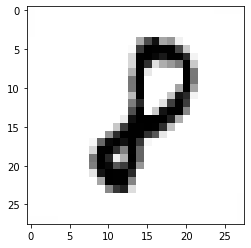

In [8]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

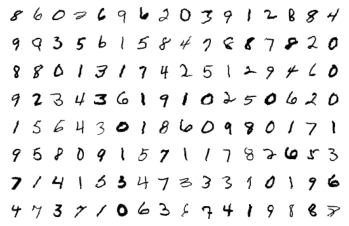

In [9]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

### Network

In [10]:
import torch.nn as nn # for network


In [11]:
# drop_out_value = 0.1

# class Network(nn.Module):
#   def __init__(self, mode = None):
#     super(Network,self).__init__() # extending super class method
#     self.mode = mode
#     print ("mode :", mode)

#     # Input Block
#     self.convblock1 = nn.Sequential(
#         nn.Conv2d(1,12,3), # In- 1x28x28, Out- 12x26x26, RF- 3x3, Jump_in -1, Jump_out -1
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(12),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm1 = nn.BatchNorm2d(12) # BatchNorm
#     if mode == "LN":
#       self.norm1 = nn.LayerNorm([12,26,26]) # Layer Norm
#     if mode == "GN":
#       self.norm1 = nn.GroupNorm(2,12) # Group Norm

#     self.dropout1 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------

#     # Conv Block 2
#     self.convblock2 = nn.Sequential(
#         nn.Conv2d(12,12,3), # In- 12x26x26, Out- 12x24x24, RF- 5x5, Jump_in -1, Jump_out -1
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(12),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm2 = nn.BatchNorm2d(12) # BatchNorm
#     if mode == "LN":
#       self.norm2 = nn.LayerNorm([12,24,24]) # Layer Norm
#     if mode == "GN":
#       self.norm2 = nn.GroupNorm(2,12) # Group Norm

#     self.dropout2 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------


#     # Conv Block 3
#     self.convblock3 = nn.Sequential(
#         nn.Conv2d(12,12,3), # In- 12x24x24, Out- 12x22x22, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(12),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm3 = nn.BatchNorm2d(12) # BatchNorm
#     if mode == "LN":
#       self.norm3 = nn.LayerNorm([12,22,22]) # Layer Norm
#     if mode == "GN":
#       self.norm3 = nn.GroupNorm(2,12) # Group Norm

#     self.dropout3 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------

#     self.convblock3_1 = nn.Sequential(
#         nn.Conv2d(12,12,3), # In- 12x22x22, Out- 12x20x20, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(12),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm3_1 = nn.BatchNorm2d(12) # BatchNorm
#     if mode == "LN":
#       self.norm3_1 = nn.LayerNorm([12,20,20]) # Layer Norm
#     if mode == "GN":
#       self.norm3_1 = nn.GroupNorm(2,12) # Group Norm

#     self.dropout3_1 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------

#     self.convblock3_2 = nn.Sequential(
#         nn.Conv2d(12,12,3), # In- 12x20x20, Out- 12x18x18, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(12),
#         # nn.Dropout(drop_out_value)
#     )

#     if mode =="BN":
#       self.norm3_2 = nn.BatchNorm2d(12) # BatchNorm
#     if mode == "LN":
#       self.norm3_2 = nn.LayerNorm([12,18,18]) # Layer Norm
#     if mode == "GN":
#       self.norm3_2 = nn.GroupNorm(2,12) # Group Norm

#     self.dropout3_2 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------
    

#     #### Transition Block 1 
#     self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 12x18x18 Out- 12x9x9 RF- 8x8, Jump_in -1, Jump_out -2


#     # Conv Block 5
#     self.convblock5 = nn.Sequential(
#         nn.Conv2d(12,16,3), # In- 12x9x9 Out- 16x7x7 RF- 12x12, Jump_in -2, Jump_out -2
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(16),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm5 = nn.BatchNorm2d(16) # BatchNorm
#     if mode == "LN":
#       self.norm5 = nn.LayerNorm([16,7,7]) # Layer Norm
#     if mode == "GN":
#       self.norm5 = nn.GroupNorm(2,16) # Group Norm

#     self.dropout5 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------

#     # Conv Block 6
#     self.convblock6 = nn.Sequential(
#         nn.Conv2d(16,16,3), # In- 16x7x7 Out- 16x5x5 RF- 16x16, Jump_in -2, Jump_out -2
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(16),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm6 = nn.BatchNorm2d(16) # BatchNorm
#     if mode == "LN":
#       self.norm6 = nn.LayerNorm([16,5,5]) # Layer Norm
#     if mode == "GN":
#       self.norm6 = nn.GroupNorm(2,16) # Group Norm

#     self.dropout6 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------

#     # Output Block
#     self.convblock7 = nn.Sequential(
#         nn.Conv2d(16,10,1), # In- 16x5x5 Out- 10x5x5, RF- 16x16, Jump_in -2, Jump_out -2
#         nn.ReLU()
#         # ,
#         # nn.BatchNorm2d(10),
#         # nn.Dropout(drop_out_value)
#     ) 

#     if mode =="BN":
#       self.norm7 = nn.BatchNorm2d(10) # BatchNorm
#     if mode == "LN":
#       self.norm7 = nn.LayerNorm([10,5,5]) # Layer Norm
#     if mode == "GN":
#       self.norm7 = nn.GroupNorm(2,10) # Group Norm

#     self.dropout7 = nn.Dropout(drop_out_value) # drop out
#     ###---------------------------------------------------

#     self.gap = nn.AvgPool2d(5) # In- 10x5x5, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2

  
#   def forward(self,x):

#     x = self.convblock1(x)
#     if mode: 
#       x = self.norm1(x)
#     x = self.dropout1(x)


#     x = self.convblock2(x)
#     if mode: 
#       x = self.norm2(x)
#     x = self.dropout2(x)
  

#     x = self.convblock3(x)
#     if mode: 
#       x = self.norm3(x)
#     x = self.dropout3(x)

#     x = self.convblock3_1(x)
#     if mode: 
#       x = self.norm3_1(x)
#     x = self.dropout3_1(x)

#     x = self.convblock3_2(x)
#     if mode: 
#       x = self.norm3_2(x)
#     x = self.dropout3_2(x)

#     x = self.pool1(x)

#     x = self.convblock5(x)
#     if mode: 
#       x = self.norm5(x)
#     x = self.dropout5(x)


#     x = self.convblock6(x)
#     if mode: 
#       x = self.norm6(x)
#     x = self.dropout6(x)

#     x = self.convblock7(x)
#     if mode: 
#       x = self.norm7(x)
#     x = self.dropout7(x)


#     x = self.gap(x)

#     # Flattening
#     x = x.view(-1,10)
#     return F.log_softmax(x,dim=-1)

# # model = Network(mode="GN")
# # print(model)

### Model Params
  - Checking the model summary and number of parameters

In [12]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
# mode = 'BN'
# mode = 'LN'
# mode ='GN'
# lambda_l1 = 0.01 
lambda_l1 = 0.001 

list_mode = ['BN','LN','GN']
for mode in list_mode:
  # mode = None
  print (f'------------Normalization : {mode}-------------')
  model = Network(mode=mode).to(device)
  # print(model)
  summary(model, input_size=(1, 28, 28))

cuda
------------Normalization : BN-------------
mode : BN


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,308
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
           Conv2d-13           [-1, 12, 20, 20]           1,308
             ReLU-14           [-1, 12,

### Training and Testing
- includes test and train functions
- includes loop function, where test can happen after each epoch is trained


In [13]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch,regularization=None):
  model.train() # setting the model in training 
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    # l1 = 0
    ########-------L1-Block- starts ----------
    if (regularization == 'L1'):
      l1=0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1
    ########-------L1-Block- ends ----------

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    if (regularization == 'L1'):
        pbar.set_description(desc= f'L1 Regularization : Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    else:
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_accuracy.append(100*correct/processed)


In [14]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))


mode : LN
------Normalization = LN , Regularization = None------
EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=2.464141845703125 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s]



Test set: Average loss: 0.0045, Accuracy: 959/10000 (9.59%)

EPOCH: 1


Loss=2.5160982608795166 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]



Test set: Average loss: 0.0041, Accuracy: 959/10000 (9.59%)

EPOCH: 2


Loss=2.5449957847595215 Batch_id=468 Accuracy=9.88: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]



Test set: Average loss: 0.0042, Accuracy: 959/10000 (9.59%)

EPOCH: 3


Loss=2.498385190963745 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]



Test set: Average loss: 0.0041, Accuracy: 959/10000 (9.59%)

EPOCH: 4


Loss=2.5618953704833984 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]



Test set: Average loss: 0.0047, Accuracy: 959/10000 (9.59%)

EPOCH: 5


Loss=2.5023910999298096 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]



Test set: Average loss: 0.0042, Accuracy: 959/10000 (9.59%)

EPOCH: 6


Loss=2.5275747776031494 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]



Test set: Average loss: 0.0043, Accuracy: 959/10000 (9.59%)

EPOCH: 7


Loss=2.484459638595581 Batch_id=468 Accuracy=9.88: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]



Test set: Average loss: 0.0041, Accuracy: 959/10000 (9.59%)

EPOCH: 8


Loss=2.5350382328033447 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]



Test set: Average loss: 0.0044, Accuracy: 959/10000 (9.59%)

EPOCH: 9


Loss=2.5558922290802 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]



Test set: Average loss: 0.0044, Accuracy: 959/10000 (9.59%)

EPOCH: 10


Loss=2.544997453689575 Batch_id=468 Accuracy=9.88: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]



Test set: Average loss: 0.0044, Accuracy: 959/10000 (9.59%)

EPOCH: 11


Loss=2.4864399433135986 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s]



Test set: Average loss: 0.0045, Accuracy: 959/10000 (9.59%)

EPOCH: 12


Loss=2.5381529331207275 Batch_id=468 Accuracy=9.90: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]



Test set: Average loss: 0.0045, Accuracy: 959/10000 (9.59%)

EPOCH: 13


Loss=2.618185520172119 Batch_id=468 Accuracy=9.88: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]



Test set: Average loss: 0.0037, Accuracy: 959/10000 (9.59%)

EPOCH: 14


Loss=2.4886703491210938 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]



Test set: Average loss: 0.0045, Accuracy: 959/10000 (9.59%)

EPOCH: 15


Loss=2.4018261432647705 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s]



Test set: Average loss: 0.0035, Accuracy: 959/10000 (9.59%)

EPOCH: 16


Loss=2.5266079902648926 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]



Test set: Average loss: 0.0042, Accuracy: 959/10000 (9.59%)

EPOCH: 17


Loss=2.5905115604400635 Batch_id=468 Accuracy=9.90: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]



Test set: Average loss: 0.0042, Accuracy: 959/10000 (9.59%)

EPOCH: 18


Loss=2.518378257751465 Batch_id=468 Accuracy=9.89: 100%|██████████| 469/469 [00:27<00:00, 16.89it/s]



Test set: Average loss: 0.0040, Accuracy: 959/10000 (9.59%)

EPOCH: 19


Loss=2.5425541400909424 Batch_id=468 Accuracy=9.88: 100%|██████████| 469/469 [00:28<00:00, 16.72it/s]



Test set: Average loss: 0.0041, Accuracy: 959/10000 (9.59%)

mode : GN
------Normalization = GN , Regularization = None------
EPOCH: 0


Loss=2.388282537460327 Batch_id=468 Accuracy=12.11: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]



Test set: Average loss: 0.0038, Accuracy: 1281/10000 (12.81%)

EPOCH: 1


Loss=2.4044971466064453 Batch_id=468 Accuracy=12.21: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]



Test set: Average loss: 0.0039, Accuracy: 1281/10000 (12.81%)

EPOCH: 2


Loss=2.361280679702759 Batch_id=468 Accuracy=12.30: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]



Test set: Average loss: 0.0037, Accuracy: 1281/10000 (12.81%)

EPOCH: 3


Loss=2.3259127140045166 Batch_id=468 Accuracy=12.44: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]



Test set: Average loss: 0.0040, Accuracy: 1281/10000 (12.81%)

EPOCH: 4


Loss=2.3745276927948 Batch_id=468 Accuracy=12.36: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s]



Test set: Average loss: 0.0039, Accuracy: 1281/10000 (12.81%)

EPOCH: 5


Loss=2.327876329421997 Batch_id=468 Accuracy=12.31: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]



Test set: Average loss: 0.0037, Accuracy: 1281/10000 (12.81%)

EPOCH: 6


Loss=2.323529005050659 Batch_id=468 Accuracy=12.28: 100%|██████████| 469/469 [00:28<00:00, 16.46it/s]



Test set: Average loss: 0.0038, Accuracy: 1281/10000 (12.81%)

EPOCH: 7


Loss=2.3283722400665283 Batch_id=468 Accuracy=12.25: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s]



Test set: Average loss: 0.0040, Accuracy: 1281/10000 (12.81%)

EPOCH: 8


Loss=2.339836835861206 Batch_id=468 Accuracy=12.30: 100%|██████████| 469/469 [00:28<00:00, 16.61it/s]



Test set: Average loss: 0.0039, Accuracy: 1281/10000 (12.81%)

EPOCH: 9


Loss=2.3641018867492676 Batch_id=468 Accuracy=12.46: 100%|██████████| 469/469 [00:28<00:00, 16.75it/s]



Test set: Average loss: 0.0040, Accuracy: 1281/10000 (12.81%)

EPOCH: 10


Loss=2.436647415161133 Batch_id=468 Accuracy=12.23: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]



Test set: Average loss: 0.0037, Accuracy: 1281/10000 (12.81%)

EPOCH: 11


Loss=2.3325235843658447 Batch_id=468 Accuracy=12.41: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]



Test set: Average loss: 0.0038, Accuracy: 1281/10000 (12.81%)

EPOCH: 12


Loss=2.3437812328338623 Batch_id=468 Accuracy=12.24: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]



Test set: Average loss: 0.0034, Accuracy: 1281/10000 (12.81%)

EPOCH: 13


Loss=2.3509914875030518 Batch_id=468 Accuracy=12.26: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]



Test set: Average loss: 0.0036, Accuracy: 1281/10000 (12.81%)

EPOCH: 14


Loss=2.3310418128967285 Batch_id=468 Accuracy=12.32: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]



Test set: Average loss: 0.0037, Accuracy: 1281/10000 (12.81%)

EPOCH: 15


Loss=2.3651702404022217 Batch_id=468 Accuracy=12.23: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s]



Test set: Average loss: 0.0039, Accuracy: 1281/10000 (12.81%)

EPOCH: 16


Loss=2.4220573902130127 Batch_id=468 Accuracy=12.21: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]



Test set: Average loss: 0.0037, Accuracy: 1281/10000 (12.81%)

EPOCH: 17


Loss=2.324707508087158 Batch_id=468 Accuracy=12.21: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]



Test set: Average loss: 0.0037, Accuracy: 1281/10000 (12.81%)

EPOCH: 18


Loss=2.3714070320129395 Batch_id=468 Accuracy=12.43: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]



Test set: Average loss: 0.0038, Accuracy: 1281/10000 (12.81%)

EPOCH: 19


Loss=2.308112859725952 Batch_id=468 Accuracy=12.21: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]



Test set: Average loss: 0.0038, Accuracy: 1281/10000 (12.81%)

mode : BN
------Normalization = BN , Regularization = L1------
EPOCH: 0


L1 Regularization : Loss=2.9254353046417236 Batch_id=468 Accuracy=10.24: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]



Test set: Average loss: 0.0034, Accuracy: 1174/10000 (11.74%)

EPOCH: 1


L1 Regularization : Loss=2.8580381870269775 Batch_id=468 Accuracy=10.26: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]



Test set: Average loss: 0.0037, Accuracy: 1181/10000 (11.81%)

EPOCH: 2


L1 Regularization : Loss=2.856795310974121 Batch_id=468 Accuracy=10.53: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s]



Test set: Average loss: 0.0036, Accuracy: 1191/10000 (11.91%)

EPOCH: 3


L1 Regularization : Loss=2.907341241836548 Batch_id=468 Accuracy=10.15: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]



Test set: Average loss: 0.0037, Accuracy: 1177/10000 (11.77%)

EPOCH: 4


L1 Regularization : Loss=2.881720781326294 Batch_id=468 Accuracy=10.50: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]



Test set: Average loss: 0.0035, Accuracy: 1196/10000 (11.96%)

EPOCH: 5


L1 Regularization : Loss=2.909135580062866 Batch_id=468 Accuracy=10.41: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s]



Test set: Average loss: 0.0037, Accuracy: 1197/10000 (11.97%)

EPOCH: 6


L1 Regularization : Loss=2.929793119430542 Batch_id=468 Accuracy=10.48: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.0038, Accuracy: 1189/10000 (11.89%)

EPOCH: 7


L1 Regularization : Loss=2.876110315322876 Batch_id=468 Accuracy=10.25: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]



Test set: Average loss: 0.0037, Accuracy: 1192/10000 (11.92%)

EPOCH: 8


L1 Regularization : Loss=2.9044079780578613 Batch_id=468 Accuracy=10.41: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]
L1 Regularization : Loss=2.8866961002349854 Batch_id=468 Accuracy=10.25: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]



Test set: Average loss: 0.0038, Accuracy: 1191/10000 (11.91%)

EPOCH: 10


L1 Regularization : Loss=2.9281346797943115 Batch_id=468 Accuracy=10.31: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s]



Test set: Average loss: 0.0038, Accuracy: 1181/10000 (11.81%)

EPOCH: 11


L1 Regularization : Loss=2.895695686340332 Batch_id=468 Accuracy=10.46: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]



Test set: Average loss: 0.0036, Accuracy: 1185/10000 (11.85%)

EPOCH: 12


L1 Regularization : Loss=2.845714807510376 Batch_id=468 Accuracy=10.34: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]



Test set: Average loss: 0.0035, Accuracy: 1192/10000 (11.92%)

EPOCH: 13


L1 Regularization : Loss=2.9150350093841553 Batch_id=468 Accuracy=10.44: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]



Test set: Average loss: 0.0036, Accuracy: 1181/10000 (11.81%)

EPOCH: 14


L1 Regularization : Loss=2.8799331188201904 Batch_id=468 Accuracy=10.51: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s]



Test set: Average loss: 0.0038, Accuracy: 1192/10000 (11.92%)

EPOCH: 15


L1 Regularization : Loss=2.8621323108673096 Batch_id=468 Accuracy=10.34: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]



Test set: Average loss: 0.0037, Accuracy: 1190/10000 (11.90%)

EPOCH: 16


L1 Regularization : Loss=2.918911933898926 Batch_id=468 Accuracy=10.53: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s]



Test set: Average loss: 0.0036, Accuracy: 1193/10000 (11.93%)

EPOCH: 17


L1 Regularization : Loss=2.912904977798462 Batch_id=468 Accuracy=10.48: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.0036, Accuracy: 1184/10000 (11.84%)

EPOCH: 18


L1 Regularization : Loss=2.916029214859009 Batch_id=468 Accuracy=10.43: 100%|██████████| 469/469 [00:31<00:00, 15.13it/s]



Test set: Average loss: 0.0036, Accuracy: 1188/10000 (11.88%)

EPOCH: 19


L1 Regularization : Loss=2.9052584171295166 Batch_id=468 Accuracy=10.53: 100%|██████████| 469/469 [00:31<00:00, 14.98it/s]



Test set: Average loss: 0.0037, Accuracy: 1196/10000 (11.96%)



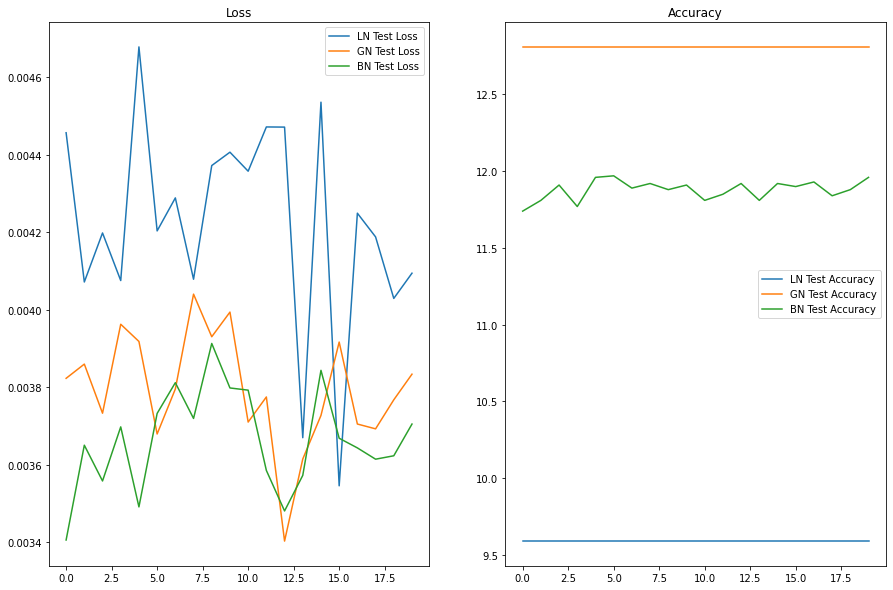

In [15]:
from torch.optim.lr_scheduler import StepLR
# list_mode =['BN']
# list_mode = ['BN','LN']
list_mode = ['LN','GN','BN']
models=[None]*len(list_mode)
# EPOCHS = 2
EPOCHS = 20

fig, axs = plt.subplots(1,2,figsize=(15,10))

for idx,mode in enumerate(list_mode):
  models[idx]=Network(mode=mode).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  # scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
  
  if mode == 'BN':
    regularization='L1'
  else:
    regularization=None
  
  train_losses = [] # to capture train losses over training epochs
  train_accuracy = [] # to capture train accuracy over training epochs
  test_losses = [] # to capture test losses 
  test_accuracy = [] # to capture test accuracy 
  # summary(models[idx], input_size=(1, 28, 28))

  print(f'------Normalization = {mode} , Regularization = {regularization}------')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(models[idx], device, train_loader, optimizer, epoch, regularization=regularization)
    test(models[idx], device, test_loader)
  # for idx,mode in enumerate(list_mode):
  # axs[0].plot(train_losses,label = str(mode)+ " Train Loss")
  # axs[0].plot(test_losses,label = str(mode)+' Test loss')
  # axs[0].set_title("Loss")
  # axs[0].legend()
  # axs[1].plot(train_accuracy,label = str(mode)+ " Train Accuracy")
  # axs[1].plot(test_accuracy,label = str(mode)+ ' Test Accuracy')
  # axs[1].set_title("Accuracy")
  # axs[1].legend()
  ######################
  # axs[0].plot(train_losses,label = str(mode)+ " Train Loss")
  axs[0].plot(test_losses,label = str(mode)+ " Test Loss")
  axs[0].set_title("Loss")
  axs[0].legend()
  # axs[1].plot(train_accuracy,label = str(mode)+ " Train Accuracy")
  axs[1].plot(test_accuracy, label = str(mode)+ ' Test Accuracy')
  axs[1].set_title("Accuracy")
  axs[1].legend()
  ######################


### Plotting Misclassified images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


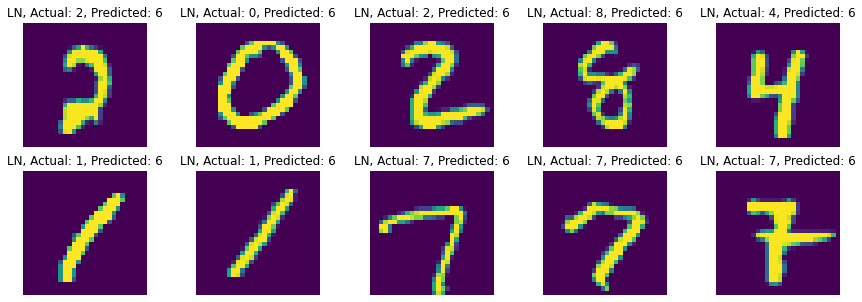

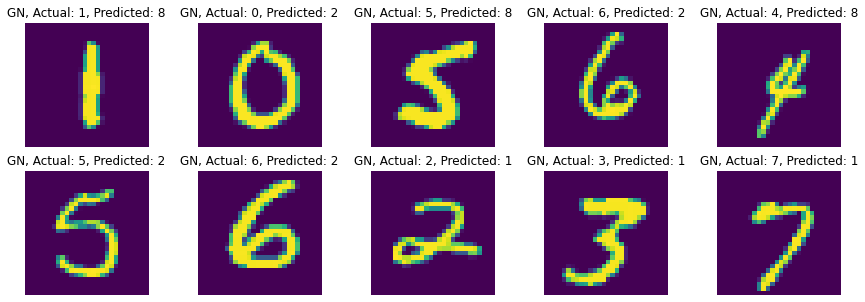

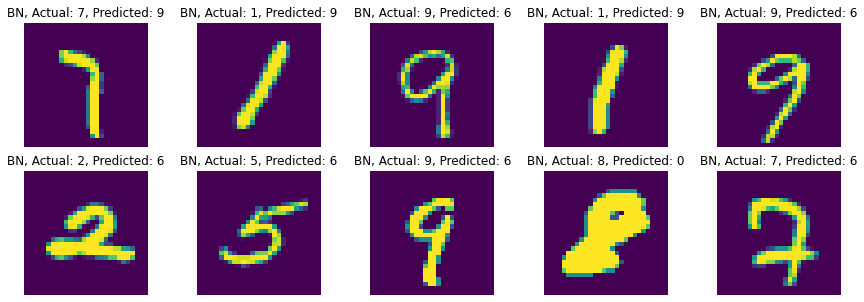

In [16]:
# Plotting misclassified Images

for idx,mode in enumerate(list_mode):
  # print(models[idx])
  incorrect_image_list =[]
  predicted_label_list =[]
  correct_label_list = []
  # incorrect = 0
  for i,(images,labels) in enumerate(test_loader):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    outputs = models[idx](images) # forward pass, result captured in outputs (plural as there are many images in a batch)
    # preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    # incorrect += preds.neq(labels.view_as(preds))
    # print(incorrect)
    # break
    preds = outputs.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (preds !=  labels).view(-1)
    img_nm = images[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(preds[idxs_mask].cpu().numpy())
        correct_label_list.extend(labels[idxs_mask].cpu().numpy())
  plt.figure(figsize=(15,5))
  i= 0
  # Display the list of 10 misclassified images
  for index, image in enumerate(incorrect_image_list) :
      ax = plt.subplot(2, 5, i+1)
      ax.set_title(str(mode) + ", Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
      ax.axis('off')
      plt.imshow(image)
      i +=1
      if i==10:
          break
 
